<a href="https://colab.research.google.com/github/hank199599/data_science_from_scratch_reading_log/blob/main/Chapter19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深度學習(Deep learning)
原本指的是「深度」神經網路，現被用來泛指各種神經網路。

# 張量
在神經網路函示庫中，n維陣列被稱為**張量(tensor)**  
理想情況下，可以使用：

```python
# 張量Tensor要不是一個浮點數，就是一個張量列表
Tensor = Union[float,List[Tensor]]
```


In [ ]:
#如同我們說：
Tensor = list

### 輔助函式：找出張量的形狀

In [ ]:
from typing import List

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes

In [ ]:
assert shape([1,2,3]) == [3]

In [ ]:
assert shape([[1,2],[3,4],[5,6]]) == [3,2]

由於張量可能具有任意數量的維度，  
因此在使用張量時，通常需要採用**遞迴**的作法。

In [ ]:
def is_1d(tensor:Tensor) ->bool:
  """
  如果tensor[0]是一個列表，他就是一個高維張量
  否則就是一個一維向量
  """
  return not isinstance(tensor[0],list)

In [ ]:
assert is_1d([1,2,3])

In [ ]:
assert not is_1d([[1,2],[3,4]])

### 輔助函式：tensor_sum 函數

In [ ]:
def tensor_sum(tensor:Tensor)->float:
  """把張量的所有值加總起來"""
  if is_1d(tensor):
    return sum(tensor) #只是一個浮點數列表，就用Python的sum函式
  else:
    return sum(tensor_sum(tensor_i) for tensor_i in tensor)

In [ ]:
assert tensor_sum([1,2,3]) == 6

In [ ]:
assert tensor_sum([[1,2],[3,4]]) == 10

### 輔助函式：把某個函數套用到單一張量中的每個元素

In [ ]:
from typing import Callable

def tensor_apply(f:Callable[[float],float],tensor:Tensor) ->Tensor:
  """把函式f套用到每個元素"""
  if is_1d(tensor):
    return [f(x) for x in tensor]
  else:
    return [tensor_apply(f,tensor_i) for tensor_i in tensor]

In [ ]:
assert tensor_apply(lambda x:x+1,[1,2,3]) == [2,3,4]

In [ ]:
assert tensor_apply(lambda x:2*x,[[1,2],[3,4]]) == [[2,4],[6,8]]

### 輔助函式：依據張量形狀，建立另一個形狀一樣的零張量

In [ ]:
def zero_like(tensor:Tensor) ->Tensor:
  return tensor_apply(lambda _: 0.0,tensor)

In [ ]:
assert zero_like([1,2,3]) == [0,0,0]

In [ ]:
assert zero_like([[1,2],[3,4]]) == [[0,0],[0,0]]

### 輔助函式：將某個函式套用到兩個張量

In [ ]:
def tensor_combine(f:Callable[[float,float],float],t1:Tensor,t2:Tensor) ->Tensor:
  """把函式f套用到t1與t2的相應元素"""
  if is_1d(t1):
    return [f(x,y) for x,y in zip(t1,t2)]
  else:
    return [tensor_combine(f,t1_i,t2_i) for t1_i,t2_i in zip(t1,t2)]

In [ ]:
import operator
assert tensor_combine(operator.add,[1,2,3],[4,5,6]) == [5,7,9]
assert tensor_combine(operator.mul,[1,2,3],[4,5,6]) == [4,10,18]

# 層的抽象概念

建立一種機制，能用來時做出各式各樣的神經網路。
最基本的概念是「Layer」。  
他知道如何把輸入套入某種函數，亦能夠進行**反向傳播**的方式計算梯度。
  
在真正的子類別中，forward 與 backward 方法都會進行實作，  
一旦建構了神經網路，我們就能以梯度遞減的方式來進行訓練。



In [ ]:
from typing import Iterable,Tuple

class Layer:
  """
  我們的神經網路是由許多層組成，其中每一層都知道
  如何以正向傳播的方式對輸入進行某些計算
  以及如何以反向傳播的方式計算梯度
  """
  def forward(self,input):
    """
    可以注意到，這裡缺了型別可以設定。
    我們並不打算限定各層的輸入是什麼型別。
    也不限定return的輸入是甚麼型別
    """
    raise NotImplementedError
  
  def backward(self,gradient):
    """
    同樣地，我們並不打算限定梯度應該是什麼型別，
    這完全由你自己決定，
    只要確定合理即可
    """
    raise NotImplementedError
  
  def params(self)->Iterable[Tensor]:
    """
    返回此層的參數，預設的實作方式不會回送任何東西。
    如果你的Layer沒有任何參數，
    並不需要實做這個方法
    """
    return ()
  
  def grads(self) ->Iterable[Tensor]:
    """
    送回梯度，順序與params相同
    """
    return ()

### 範例：不須更新參數的sigmoid層：
在正向傳遞中，保存了sigmoid函式的計算結果。  
以供後續的反向傳遞使用。


In [ ]:
from typing import List
import math

Vector = List[float]

def sigmoid(t:float)->float:
  return 1/(1+math.exp(-t))
 
class Sigmoid(Layer):
  def forward(self, input: Tensor) -> Tensor:
    """
    把sigmoid函式套用到輸入張量的每個元素，
    然後儲存結果，供反向傳播使用
    """
    self.sigmoids = tensor_apply(sigmoid, input)
    return self.sigmoids

  def backward(self, gradient: Tensor) -> Tensor:
    """
    微積分連鎖定律之定義：
    input=(predicted - actual) ** 2
    d(input)/d(grad) * d(grad)/d(sig) = sig*(1-sig)*grad
    """
    return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                                self.sigmoids,
                                gradient)


## 線性層
代表神經元的 **dot(weight,inputs)** 點積的部分
  
在這裡實作三種方式生成初始的隨機張量：
1. 自[0,1]的隨機分布中選擇初始值
2. 自標準常態分布中選擇初始值
3. 使用「Xavier initialization」，其中每個權重為平均是0，變異量為2/(num_inputs+num_outputs)的標準常態分布中選擇初始值


### 前置作業

In [ ]:
import random
import math

SQRT_TWO_PI = math.sqrt(2* math.pi)

def normal_pdf(x:float,mu:float=0,sigma:float=1) ->float:
  return (math.exp(-(x-mu)**2/2/sigma**2)/(SQRT_TWO_PI*sigma))

def normal_cdf(x:float,mu:float=0,sigma:float=1)->float:
  return (1+math.erf((x-mu)/math.sqrt(2)/sigma))/2

def inverse_normal_cdf(p:float,
            mu:float = 0,
            sigma:float = 1,
            tolerance:float=0.00001) -> float:
  # 如果不是標準常態分佈，就先轉換成標準常態分佈
  if mu != 0 or sigma != 1:
    return mu + sigma*inverse_normal_cdf(p,tolerance = tolerance)
  
  low_z = -10.0 # normal_cdf(-10)是(趨近於) 0
  hi_z =  10.0 # normal_cdf(10)是(趨近於) 1
  while hi_z - low_z > tolerance:  
    mid_z = (low_z + hi_z) / 2   # 計算出中間值
    mid_p = normal_cdf(mid_z)     # 以及累積分佈函數在該處所應對的值
    if mid_p < p :
      low_z = mid_z        #中間的值太低，就往上繼續搜尋
    else:
      hi_z = mid_z        #中間的值太高，就往下繼續搜尋
  
  return mid_z

In [ ]:
# 自[0,1]的隨機分布中選擇初始值
def random_uniform(*dims:int) ->Tensor:
  if len(dims) == 1:
    return [random.random() for _ in range(dims[0])]
  else:
    return [random_uniform(*dims[1:]) for _ in range(dims[0])]

# 自標準常態分布中選擇初始值
def random_normal(*dims:int,mean:float=0.0,variance:float=1.0) ->Tensor:
  if len(dims) == 1:
    return [mean + variance * inverse_normal_cdf(random.random()) for _ in range(dims[0])]
  else:
    return [random_normal(*dims[1:],mean=mean,variance=variance) for _ in range(dims[0])]
  

In [ ]:
assert shape(random_uniform(2,3,4)) == [2,3,4]

In [ ]:
assert shape(random_normal(5,6,mean=10)) == [5,6]

將他們包裝在random_tensor函式中

In [ ]:
def random_tensor(*dims:int,init:str = 'normal')->Tensor:
  if init == 'normal':
    return random_normal(*dims) # 自[0,1]的隨機分布中選擇初始值
  elif init == 'uniform':
    return random_uniform(*dims) # 自標準常態分布中選擇初始值
  elif init == 'xavier': 
    variance = len(dims)/sum(dims)
    return random_normal(*dims,variance=variance) #使用「Xavier initialization」，其中每個權重為平均是0，變異量為2/(num_inputs+num_outputs)的標準常態分布中選擇初始值
  else:
    raise ValueError(f"unknown init: {init}")

### 定義線性層
須提供以下資訊：  
* 輸入的維度 (每個神經元需要幾個權重)
* 輸出的維度 (有幾個神經元)

In [ ]:
def dot(v:Vector,w:Vector)->float:
  #計算v_1*w_1+... +v_n*w_n
  assert len(v)==len(w),"兩個向量必須有相同的維度"

  return sum(v_i*w_i for v_i,w_i in zip(v,w))

In [ ]:
class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        此層具有output_dims個神經元，每個神經元都有 imnput_dims個權重以及一個偏差量
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] 是第 o 個神經元的權重
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.w[o] 是第 o 個神經元的偏差項
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # 保存以供反向傳遞使用
        self.input = input

        # 送回神經元的輸出向量
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # 每個　b[o]　都會被加到　output[o]　之中
        # 亦即ｂ的梯度等於　output的梯度
        self.b_grad = gradient

        # 每個w[o][i]都會乘以input[i]再加到output[o]之中
        # 因此梯度是 input[i]*gradient[o]
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                        for o in range(self.output_dim)]

        # 每個input[i]都會與每個w[o][i]相乘，再加到每個output[o]之中
        # 因此其梯度就是橫跨所有outputs
        # w[o][i]*gradient[o]加總之和
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

# 把神經網路視為一系列的層

In [ ]:
from typing import List

class Sequential(Layer):
  """
  一行就包括一系列的其他層。
  每一層的輸出做為下一層的輸入，
  """
  def __init__(self,layers:List[Layer])->None:
    self.layers = layers
  
  def forward(self,input):
    """讓輸入照順序正向通過每一層"""
    for layer in self.layers:
      input = layer.forward(input)
    return input
  
  def backward(self,gradient):
    """讓梯度反向通過每一層以進行反向傳播"""
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)
    return gradient
  
  def params(self) ->Iterable[Tensor]:
    """送回每一層的參數"""
    return (param for layer in self.layers for param in layer.params())

  def grads(self) ->Iterable[Tensor]:
    """送回每一層的梯度"""
    return (grad for layer in self.layers for grad in layer.grads())

將XOR神經網路表示為：

In [ ]:
xor_net=Sequential([
  Linear(input_dim=2,output_dim=2),
  Sigmoid(),
  Linear(input_dim=2,output_dim=1),
  Sigmoid()])

# 損失與最佳化

### 定義名為「Loss」的抽象類別

In [ ]:
class Loss:
  def loss(self,predicted:Tensor,actual:Tensor) ->float:
    """計算我們預測結果的程度"""
    raise NotImplementedError
  
  def gradient(self,predicted:Tensor,actual:Tensor) ->Tensor:
    """如果預測改變，則損失會隨之改變"""
    raise NotImplementedError

### 利用**平方誤差和**做為損失函數

In [ ]:
class SSE(Loss):
  """計算平方誤差和，以作為損失函數"""
  def loss(self,predicted:Tensor,actual:Tensor)->float:

    #計算出平方誤差量
    squared_errors = tensor_combine(
      lambda predicted,actual:(predicted - actual) ** 2,
      predicted,
      actual)

    #接著全部加總起來
    return tensor_sum(squared_errors)
  
  def gradient(self,predicted:Tensor,actual:Tensor)->Tensor:
    return tensor_combine(
      lambda predicted,actual: 2 * (predicted - actual),
      predicted,
      actual)

In [ ]:
sse_loss = SSE()
assert sse_loss.loss([1, 2, 3], [10, 20, 30]) == 9 ** 2 + 18 ** 2 + 27 ** 2
assert sse_loss.gradient([1, 2, 3], [10, 20, 30]) == [-18, -36, -54]

### 梯度遞減的實作
以往是以人工方式完成所有梯度遞減的操作，然而在這裡不太適用。

```python
theta = gradient_step(theta,grad,-learning_rate)
```

1. 神經網路有多個參數需要更新
2. 希望能使用更聰明的梯度遞減變形作法而無須重新改寫程式

In [ ]:
class Optimizer:
  """
  Optimizer會更新layer的權重值，
  其根據不是來自layer就是來自Optimizer
  """
  def step(self,layer:Layer) ->None:
    raise NotImplementedError

利用Optimizer來實作梯度遞減



In [ ]:
class GradientDescent(Optimizer):
  def __init__(self,learning_rate:float=0.1)->None:
    self.lr = learning_rate
  
  def step(self,layer:Layer) ->None:
    for param,grad in zip(layer.params(),layer.grads()):
      #運用梯度遞減的方式更新參數
      param[:] = tensor_combine(
        lambda param,grad:param - grad * self.lr,
        param,
        grad
      )

### 片段指定值(slice assignment)
**反映一個事實**：重新指定列表的值，並不會改變其值


```python
tensor= [[1,2],[3,4]]

for row in tensor:
  row = [0,0]

assert tensor == [[1,2],[3,4]] #一般指定值的方式不會更動到列表內容

for row in tensor:
  row[:] = [0,0]

assert tensor == [[0,0],[0,0]] #  片段指定值的方式就會更動到列表內容
```



### 動量(momentum)
保留先前梯度移動平均值，每得到新的梯度值就更新這個平均梯度值並往這個平均方向邁開一步。

In [ ]:
class Momentum(Optimizer):
  def __init__(self,learning_rate:float,momentum:float=0.9) ->None:
    self.lr = learning_rate
    self.mo = momentum
    self.updates:List[Tensor]=[] #移動平均

  def step(self,layer:Layer)->None:
    #如果還沒有之前的更新值，就全部使用零來當作起始值
    if not self.updates:
      self.updates = [zero_like(grad) for grad in layer.grads()]
    
    for update,param,grad in zip(self.updates,layer.params(),layer.grads()):
      #套用動量的計算方式
      update[:] = tensor_combine(lambda u,g:self.mo * u + (1 - self.mo) * g, update , grad)

      #接著執行梯度遞減的步驟
      param[:] = tensor_combine(lambda p,u:p-self.lr*u,param,update)

# 範例：XOR再次嘗試

重新建立訓練資料

In [ ]:
xs = [[0.,0],[0.,1],[1.,0],[1.,1]]
ys = [[0.],[1.],[1.],[0.]]

定義網路  
(*在這裡可以省去最後的sigmoid層*)

In [ ]:
random.seed(1)

net = Sequential([
  Linear(input_dim=2,output_dim=2),
  Sigmoid(),
  Linear(input_dim=2,output_dim=1)
])

定義一個簡易的定義迴圈

In [ ]:
import tqdm

optimizer = GradientDescent(learning_rate=0.1)
loss = SSE()

with tqdm.trange(3000) as t:
    for epoch in t:
        epoch_loss = 0.0

        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)

            optimizer.step(net)

        t.set_description(f"xor loss {epoch_loss:.3f}")


xor loss 0.000: 100%|██████████| 3000/3000 [00:05<00:00, 560.37it/s]


檢查訓練後的網路

In [ ]:
for param in net.params():
  print(param)

[[-2.7093966262104487, 2.653711088340027], [2.2917078536634508, -2.251697656785721]]
[-1.894089978443923, -1.450879940018008]
[[2.594140810886788, 2.5817610835024105]]
[-0.8294478276015247]


從得到的網路來看，結果大致如下：
* hidden1 = -2.6 * x1 + -2.7 * x2 + 0.2
* hidden2 = 2.1 * x1 + 2.1 * x2 -3.4
* optput= -3.1 * h1 + -2.6 * x2 + 1.8

# 其他激活函數

## 雙曲正切函數( tanh, 雙曲正切函數)

In [ ]:
import math

def tanh(x:float) ->float:
  # 如果x非常大或非常小，tanh就會非常接近-1或1
  # 由於math.exp(1000)會發生錯誤，因此需要檢查
  if x < -100 : return -1
  elif x > 100 : return 1

  emx2 = math.exp(-2*x)
  return (1-emx2)/(1+emx2)

In [ ]:
class Tanh(Layer):
  def forward(self,input:Tensor) ->Tensor:
    #保存tanh輸出以供反向傳播使用
    self.tanh = tensor_apply(tanh,input)
    return self.tanh
  
  def backward(self,gradient:Tensor) ->Tensor:
    return tensor_combine(lambda tanh,grad:(1-tanh**2)*grad,
                self.tanh,
                gradient)

## Relu函數

In [ ]:
class Relu(Layer):
  def forward(self,input:Tensor)->Tensor:
    self.input = input
    return tensor_apply(lambda x:max(x,0),input)
  
  def backward(self,gradient:Tensor)->Tensor:
    return tensor_combine(lambda x,grad:grad if x >0 else 0, self.input,gradient)

# **範例**：FizzBuzz 再次嘗試

In [ ]:
#引入上一章建立的函式
def binary_encode(x:int)->Vector:
  binary:List[float] = []

  for i in range(10):
    binary.append(x%2)
    x = x // 2
  
  return binary


def fizz_buzz_encode(x:int)->Vector:
  if x%15 == 0 :
    return [0,0,0,1]
  if x%5 == 0 :
    return [0,0,1,0]
  if x%3 == 0 :
    return [0,1,0,0]
  else:
    return [1,0,0,0]

def argmax(xs:list) ->int:
  """送回最大值相應的索引值"""
  return max(range(len(xs)), key = lambda i:xs[i])

In [ ]:
xs = [binary_encode(n) for n in range(101,1024)]
ys = [fizz_buzz_encode(n) for n in range(101,1024)] 

建立網路

In [ ]:
NUM_HIDDEN = 25

random.seed(0)

net = Sequential([
    Linear(input_dim=10,output_dim=NUM_HIDDEN,init='uniform'),
    Tanh(),
    Linear(input_dim=NUM_HIDDEN,output_dim=4,init='uniform'),
    Sigmoid()
])

進行訓練時，我們須同時追蹤訓練組資料的正確率變化：

In [ ]:
def fizzbuzz_accuracy(low:int,hi:int,net:Layer)->float:
  num_correct = 0
  for n in range(low,hi):
    x = binary_encode(n)
    predicted = argmax(net.forward(x))
    actual = argmax(fizz_buzz_encode(n))

    if predicted == actual:
      num_correct += 1
    
  return num_correct/(hi-low)

In [ ]:
optimizer = Momentum(learning_rate=0.1,momentum=0.9)
loss = SSE()

with tqdm.trange(1000) as t:
  for epoch in t:

    epoch_loss = 0.0

    for x,y in zip(xs,ys):
      predicted = net.forward(x)
      epoch_loss += loss.loss(predicted,y)
      gradient = loss.gradient(predicted,y)
      net.backward(gradient)

      optimizer.step(net)
    
    accuracy = fizzbuzz_accuracy(101,1024,net)
    t.set_description(f"fb loss:{epoch_loss:.2f} acc:{accuracy:.2f}")

#將測試組資料的結果列印出來
print()
print("test results",fizzbuzz_accuracy(1,101,net))

fb loss:64.54 acc:0.95: 100%|██████████| 1000/1000 [08:32<00:00,  1.95it/s]


test results 0.9


經過1000次的迭代訓練後，該模型可以在測試組資料上獲得90%以上的正確率。

# Softmax與交叉熵

## Softmax 函數
為了使輸出類別分類時能**以機率來表示可能性**，會採用softmax函數。
該函數會將數值向量轉換成機率值向量。  
1. 計算出向量中每個數值的exp(x)
2. 把每個正值除以所有值的總和 (即 **機率向量** )

In [ ]:
def softmax(tensor:Tensor) -> Tensor:
  """沿著最後一個維度，進行Softmax計算"""
  if is_1d(tensor):
    #考慮數值穩定性，先減去最大值
    largest = max(tensor)
    exps = [math.exp( x - largest ) for x in tensor]

    sum_of_steps = sum(exps)
    return [exp_i / sum_of_steps for exp_i in exps]
  
  else:
    return [softmax(tensor_i) for tensor_i in tensor]

## 交叉熵 (Cross - entropy)
代表觀測資料的負對數可能性
  
如果最小化這個損失，即最大化訓練資料的對數可能性

In [ ]:
class SoftmaxCrossEntropy(Loss):
  """
  這就是在給定神經網路模型的情形下，觀察值的負對數可能性。
  因此，選擇的權重值若能最小化負對數可能性，
  也就相當於最大化觀測資料的可能性。
  """
  def loss(self,predicted:Tensor,actual:Tensor)->float:
    # 套用softmax取得機率值
    probabilities = softmax(predicted)

    # 如果是正確的分類i，其值就是log p_i 其他對應類別則為零
    # 我們會幫p加上一個黑小的值，避免出現log(0)的情況
    likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                    probabilities,
                                    actual)

    # 接著全部加總起來，再取負值
    return -tensor_sum(likelihoods)
  
  def gradient(self,predicted:Tensor,actual:Tensor)->Tensor:
    probabilities = softmax(predicted)

    return tensor_combine(lambda p,actual:p-actual,
                        probabilities,
                        actual)

### 利用SoftmaxCrossEntropy進行嘗試

In [ ]:
xs = [binary_encode(n) for n in range(101,1024)]
ys = [fizz_buzz_encode(n) for n in range(101,1024)] 

random.seed(0)

NUM_HIDDEN=25

net = Sequential([
    Linear(input_dim=10,output_dim=NUM_HIDDEN,init='uniform'),
    Tanh(),
    Linear(input_dim=NUM_HIDDEN,output_dim=4,init='uniform')
    #現在最後面不是Sigmoid層了
])


optimizer = Momentum(learning_rate=0.1,momentum=0.9)
loss = SoftmaxCrossEntropy()

with tqdm.trange(100) as t:
  for epoch in t:
    epoch_loss = 0.0

    for x,y in zip(xs,ys):
      predicted = net.forward(x)
      epoch_loss += loss.loss(predicted,y)
      gradient = loss.gradient(predicted,y)
      net.backward(gradient)

      optimizer.step(net)
    
    accuracy = fizzbuzz_accuracy(101,1024,net)
    t.set_description(f"fb loss:{epoch_loss:.2f} acc:{accuracy:.2f}")

#將測試組資料的結果列印出來
print()
print("test results",fizzbuzz_accuracy(1,101,net))

fb loss:6.12 acc:1.00: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


test results 0.97


改用SoftmaxCrossEntropy來訓練神經網路，訓練時間能更短且較容易找到結果對應的權重值。

# Dropout 隨機拋棄
用來防止神經網路出現**過擬和**的情形  
* 在訓練階段，每個神經元會依據特定機率隨機關閉→神經網路在學習時不能太過依賴單一神經元
* 在訓練階段則盡量使用到所有神經元 → **Dropout曾必須知道是否處於訓練階段**

In [ ]:
class Dropout(Layer):
  def __init__(self,p:float) ->None:
    self.p = p
    self.train = True
  
  def forward(self,input:Tensor) ->Tensor:
    if self.train:
      # 根據所輸入的機率值，建立一個由0和1組成的遮罩向量 (即建立是否開關要神經元的陣列資料)
      # 其形狀與輸入相同
      self.mask = tensor_apply(
        lambda _ : 0 if random.random() < self.p else 1,
        input
      )
  def backward(self,gradient:Tensor)->Tensor:
    if self.train:
      # 只需傳遞 mask == 1 相應位置的梯度
      return tensor_combine(operator.nul,gradient,self.mask)
    
    else:
      raise RuntimeError("don't call backeard when not in train mode")

# 範例：[MNIST](https://yann.lecun.com/exdb/mnist)
這是一個包含許多手寫數字的資料集  
由於這個資料即是相對棘手的二元格式，需要額外的函式庫來幫助



In [ ]:
!pip install mnist

## 載入訓練圖片

In [ ]:
import mnist

# 下載資料
mnist.temporary = lambda:'/content/sample_data/'

# 以下幾個函式都會先下載資料，並送回一個numpy陣列
# 之所以調用 .tolist()是因為我們宣告的「張量」實際上是列表
train_images = mnist.train_images().tolist()
train_labels = mnist.train_labels().tolist()

assert shape(train_images) == [60000,28,28]
assert shape(train_labels) == [60000]

將前100個訓練圖片提取出來

### 圖 19-1 MNIST圖片

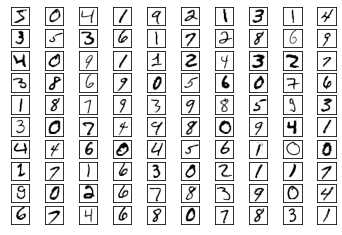

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(10,10) # 建立內含10*10子圖的圖片

for i in range(10):
  for j in range(10):
    # 以黑白格式畫出每張圖片，並隱藏軸線
    ax[i][j].imshow(train_images[10*i+j],cmap="Greys")
    ax[i][j].xaxis.set_visible(False)
    ax[i][j].yaxis.set_visible(False)

plt.show()

## 載入測試圖片

In [ ]:
test_images = mnist.test_images().tolist()
test_labels = mnist.test_labels().tolist()

assert shape(test_images) == [10000,28,28]
assert shape(test_labels) == [10000]

## 資料預處理
每張圖片都是 28x28 像素，，但我們的線性曾只能處理一維輸入。  
故要先在進行訓練前進行以下操作：
1. 將輸入資料**展平**
2. 再減去平均值 (使訓練效果更好)


In [ ]:
# 計算像素平均值
avg = tensor_sum(train_images) / 60000 / 28 / 28

#重新調整數據的中心與尺度比對
train_images = [[(pixel - avg)/256 for row in image for pixel in row] for image in train_images]
test_images = [[(pixel - avg)/256 for row in image for pixel in row] for image in test_images]

assert shape(train_images) == [60000,784],"圖片應該要先展平"
assert shape(test_images) == [10000,784],"圖片應該要先展平"

調整後，像素的平均值中心應該會很靠近0

In [ ]:
assert -0.0001 < tensor_sum(train_images) < 0.0001

## 使用 One-hot編碼的形式表示輸出結果

In [ ]:
def one_hot_encode(i:int,num_labels:int=10)->List[float]:
  return [1.0 if j==i else 0.0 for j in range(num_labels)]

In [ ]:
assert one_hot_encode(3) == [0,0,0,1,0,0,0,0,0,0]
assert one_hot_encode(2,num_labels=5) == [0,0,1,0,0]

套用到我們的資料上

In [ ]:
train_labels = [one_hot_encode(label) for label in train_labels]
test_labels = [one_hot_encode(label) for label in test_labels]

assert shape(train_labels) == [60000,10]
assert shape(test_labels) == [10000,10]

## 建立將輸入物件進行訓練的函式

In [ ]:
import tqdm

def loop(model:Layer,
     images:List[Tensor],
     labels:List[Tensor],
     loss:Loss,
     optimizer:Optimizer = None) ->None:
  
  correct = 0 #追蹤正確預測的數量
  total_loss = 0.0 #追蹤總損失值

  with tqdm.trange(len(images)) as t:
    for i in t:
      prediected = model.forward(images[i])    # 進行預測
      if argmax(predicted) == argmax(labels[i]): 
        correct += 1               # 若預測正確，則正確次數+1
      total_loss += loss.loss(predicted,labels[i]) # 計算相對損失
    
      # 若正在進行訓練，則反向傳播梯度值並更新權重值
      if optimizer is not None:
        gradient = loss.gradient(predicted,labels[i])
        model.backward(gradient)
        optimizer.step(normal)
      
      # 接著，更新進度條中的相關數值
      avg_loss = total_loss / (i+1)
      acc = correct / (i+1)
      t.set_description(f"mnist loss : {avg_loss:.3f} acc : {acc:.3f}")


在圖像辨識的模型中，本質上就是在查找10個線性函數。  
舉例來說，若輸入是5→第五個線性函數就會產生最大的輸出

### 邏輯迴歸
一個線性層 + 一個SoftMax函數

In [ ]:
random.seed(0)

model = Linear(784,10) # 邏輯迴歸
loss = SoftmaxCrossEntropy()

optimizer = Momentum(learning_rate=0.01,momentum=0.99)

#針對訓練資料進行訓練
loop(model,train_images,train_labels,loss,optimizer)

#針對測試資料進行測試(無提供optimizer代表要進行評估)
loop(model,test_images,test_labels,loss)

  0%|          | 0/60000 [00:00<?, ?it/s]


IndexError: ignored

### 改造為深度學習神經網路
兩個隱藏層  
* 第一層：30個神經元
* 第二層：10個神經元  
並採用Tanh激活函數

In [ ]:
random.seed(0)

# 取個名字以便在訓練時啟用或關閉
dropout1 = Dropout(0.1)
dropout2 = Dropout(0.1)

model = Sequential([
  Linear(784,30), # 隱藏層1：大小為10
  dropout1,
  Tanh(),
  Linear(30,10), # 隱藏層2：大小為10
  dropout2,
  Tanh(),
  Linear(10,10) # 輸出層：大小為10
])

In [ ]:
optimizer = Momentum(learning_rate=0.01,momentum=0.99)
loss = SoftmaxCrossEntropy()

#針對訓練資料進行訓練
dropout1.train = dropout2.train = True
loop(model,train_images,train_labels,loss,optimizer)

#針對測試資料進行測試(無提供optimizer代表要進行評估)
dropout1.train = dropout2.train = False
loop(model,train_images,train_labels,loss)

  0%|          | 0/60000 [00:00<?, ?it/s]


IndexError: ignored

# 模型的儲存與載入